<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/40b_Ultra_Pro_VAE%2C_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra pro

Макс 10 баллов

Возьмите любую базу достаточно простых изображений и сделайте генерацию с помощью CVAE. Добейтесь качественной генерации.

Хороший вариант базы - фото собак и кошек (kaggle cats vs dogs).

База: https://www.kaggle.com/tongpython/cat-and-dog?select=training_set

## Библиотеки

In [1]:
!pip install keras==2.0 -q # загружаем эту версию кераса для корректной работы скрипта
!pip install tensorflow==1.13.1 -q  # загружаем эту версию тензорфлоу  для корректной работы скрипта

     |████████████████████████████████| 191 kB 4.2 MB/s 
     |████████████████████████████████| 497.5 MB 25 kB/s 
     |████████████████████████████████| 495.0 MB 30 kB/s 
     |████████████████████████████████| 463.8 MB 33 kB/s 
     |████████████████████████████████| 462 kB 64.4 MB/s 
     |████████████████████████████████| 132 kB 68.0 MB/s 
     |████████████████████████████████| 458.3 MB 14 kB/s 
     |████████████████████████████████| 458.3 MB 14 kB/s 
     |████████████████████████████████| 458.3 MB 11 kB/s 
     |████████████████████████████████| 460.3 MB 9.3 kB/s 
     |████████████████████████████████| 1.2 MB 49.9 MB/s 
     |████████████████████████████████| 4.0 MB 48.3 MB/s 
     |████████████████████████████████| 462 kB 12.1 MB/s 
     |████████████████████████████████| 92.6 MB 1.1 MB/s 
     |████████████████████████████████| 50 kB 9.3 MB/s 
     |████████████████████████████████| 367 kB 74.3 MB/s 
     |████████████████████████████████| 3.2 MB 48.4 MB/s 
ERROR: pip's dep

In [ ]:
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
%matplotlib inline
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами
# import seaborn as sns

from keras.datasets import mnist # загружаем готовую стандартную базу рукописных цифр mnist
from keras.utils import to_categorical # загружаем утилиты кераса для one-hot кодировки
from keras.layers import Input, Dense # загружаем необходимые слои(входной, полносвязный)
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda # загружаем слои(нормализации, регуляризации и т.д)
from keras.layers import concatenate # подгружаем слой конкатенации
from keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса 
from keras.objectives import binary_crossentropy # импортируем функцию потерь
from keras.layers.advanced_activations import LeakyReLU # импортируем функцию активации
from keras import backend as K # устанавливаем переменную для окружения кераса
from keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки

## Загрузка данных

In [3]:
import os #
from google.colab import drive 
from keras.preprocessing import image 

In [4]:
drive.mount('/content/drive/') # монтируем google диск

Mounted at /content/drive/


In [5]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Базы/training_set.zip' 

## Формирование данных

In [6]:
os.remove('/content/training_set/dogs/_DS_Store')
os.remove('/content/training_set/cats/_DS_Store')

In [9]:
images_dir = 'training_set' 
height = 96
width = height

x_train_tmp = [] 
y_train_tmp = []
d = os.listdir('{0}/dogs'.format(images_dir))
c = os.listdir('{0}/cats'.format(images_dir))

for i in range(len(c)):
  # print(d[i])
  x_train_tmp.append(image.img_to_array(image.load_img(os.path.join('{0}/dogs'.format(images_dir), d[i]), target_size=(height, width))))
  x_train_tmp.append(image.img_to_array(image.load_img(os.path.join('{0}/cats'.format(images_dir), c[i]), target_size=(height, width))))
  y_train_tmp.append([1, 0])
  y_train_tmp.append([0, 1])

In [10]:
x_train_tmp = np.array(x_train_tmp)
x_train_tmp = x_train_tmp.astype('float32') / 255. 
x_train_tmp = np.reshape(x_train_tmp, (len(x_train_tmp), height, width, 3)) 

In [11]:
x_train_tmp.shape

(8000, 96, 96, 3)

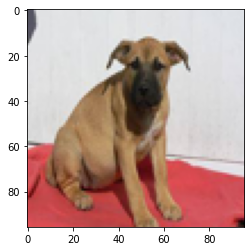

In [12]:
plt.imshow(x_train_tmp[np.random.randint(0, x_train_tmp.shape[0])].reshape(height,width,3)) #случайное изображение 
plt.show()

In [13]:
x_test = x_train_tmp[7000:8000]
x_train = x_train_tmp[:7000]
y_test_cat = y_train_tmp[7000:8000]
y_train_cat = y_train_tmp[:7000]

In [14]:
y_test_cat = np.array(y_test_cat).astype(np.float32)
y_train_cat = np.array(y_train_cat).astype(np.float32)

In [15]:
print(x_train.shape)
print(y_train_cat.shape)
print(x_test.shape)
print(y_test_cat.shape)

(7000, 96, 96, 3)
(7000, 2)
(1000, 96, 96, 3)
(1000, 2)


## Параметры

In [16]:
batch_size = 100 # размер батча
latent_dim = 80 # размер скрытого слоя
dropout_rate = 0.1 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.001 # шаг обучения
num_classes = y_test_cat.shape[1]
n = 15 # количество картинок
digit_size = height # задаем размеры
img_layers = 3

## Функции

In [17]:
def create_cvae(): # объявляем функцию создания вариационного автокодировщика c условием
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(shape=(digit_size, digit_size, img_layers)) # размерности строк, столбцов, фильтров одной картинки
    flatten_img = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    input_lbl = Input(shape=(num_classes,), dtype='float32') # второй вход в энкодер с учетом лейблов и по количеству классов

    x = concatenate([flatten_img, input_lbl]) # конкатенируем входы сглаженной входной картинки и input_lbl
    
    x = Dense(1024, activation='relu')(x) # полносвязный слой 
    
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации

    x = Dense(512, activation='relu')(x) # полносвязный слой 
    
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    
    # Предсказываем параметры распределений
    
    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) 
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации)

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        # керасовским методом делаем нормальное распределение, мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (8,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

    models["encoder"]  = Model([input_img, input_lbl], l, 'Encoder') # модель энкодера от входов до лямбда слоя
    models["z_meaner"] = Model([input_img, input_lbl], z_mean, 'Enc_z_mean') # отдельная модель с путем от входов до z_mean
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var, 'Enc_z_log_var') # отдельная модель с путем от входов до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем первую входную размерность 
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') # задаем вторую входную размерность по номеру классов
    x = concatenate([z, input_lbl_d]) # конкатенируем входы

    x = Dense(512)(x) # полносвязный слой 
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации

    x = Dense(1024)(x) # полносвязный слой 
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(digit_size*digit_size*img_layers, activation='sigmoid')(x) # полносвязный слой 
    decoded = Reshape((digit_size, digit_size, img_layers))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder') # собираем модель декодера
    
    # Cобираем вариационный автокодировщик с условием(3 инпута на входе, затем первые два проходят через энкодер,
    # складываются с input_lbl_d и всё это проходит через декодер на выходе)
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")
    
    # Та же операция, но вместо энкодера модель z_meaner
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , 
                               name="style_transfer")
    
    
    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, digit_size*digit_size*img_layers)) # меняем размеры(в одномерный) x через керасовскую функцию     
        decoded = K.reshape(decoded, shape=(batch_size, digit_size*digit_size*img_layers)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = digit_size*digit_size*img_layers*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/digit_size/digit_size/img_layers # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args] # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n, img_layers)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран    

def on_epoch_end(epoch, logs):
        clear_output()         
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

pltfig = LambdaCallback(on_epoch_end=on_epoch_end)  

## Обучение

In [ ]:
# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 2

# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')

models, vae_loss = create_cvae() # получаем модели и свою функцию потерь

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

cvae = models["cvae"] # задаем модель вариационного автокодировщика с условием
cvae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

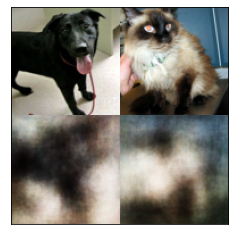

7000/7000 [==============================] - 109s - loss: 0.2937 - val_loss: 0.2938


In [19]:
# Запуск обучения 
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=30,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

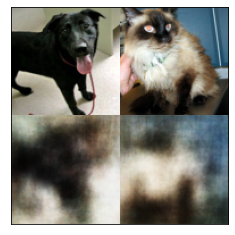

7000/7000 [==============================] - 109s - loss: 0.2922 - val_loss: 0.2910


In [20]:
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=30,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

## Результат

In [21]:
def style_transfer(model, X, lbl_in, lbl_out): # объявляем функцию переноса стилей
    rows = X.shape[0] 
    if isinstance(lbl_in, int): # заполняем входные лейблы(энкодера)
        lbl = lbl_in 
        lbl_in = np.zeros((rows, 2)) # построчное заполнение нулями от 0 до 9
        lbl_in[:, lbl] = 1 # заполняем в нужную строчку единицу
    if isinstance(lbl_out, int): # заполняем выходные лейблы(декодера)
        lbl = lbl_out
        lbl_out = np.zeros((rows, 2)) # построчное заполнение нулями от 0 до 9
        lbl_out[:, lbl] = 1 # заполняем в нужную строчку единицу
    # print(lbl_in)
    # print(lbl_out)
    return model.predict([X, lbl_in, lbl_out]) # функция вернет предсказанные картинки

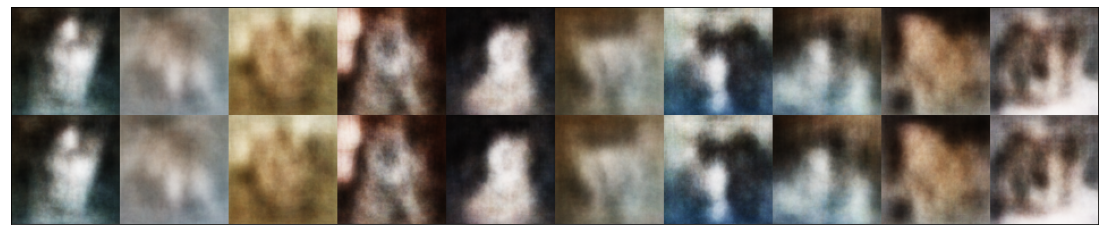

In [22]:
n = 10 # выбираем количество картинок
lbl = 0 # выбираем лейбл
generated = [] # здесь соберем список сгенерированных картинок
prot = x_train[1:20:2] # возьмем prot в качестве x с соответствующим выбранному значению лейбла 

for i in range(num_classes): # идем по каждому классу
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) # и генерим картинки с учетом переноса стиля

plot_digits(*generated) # отрисовываем картинки